In [1]:
%config IPCompleter.greedy=True
#Press Shift + Tab to trigger autocomplete.

In [2]:
!pip install -q transformers

In [1]:
#**Import Libraries :**
#@title Import and Install Libraries { vertical-output: true, display-mode: "form" }
import numpy as np
from numpy import vstack
from datasets import load_dataset
from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import (
    Compose,
    Normalize,
    ToTensor,
    Resize
)

import tensorflow as tf
import os
import PIL
from PIL import Image
import time

import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

np.random.seed(0)
torch.manual_seed(0)

print("All libraries are imported successfully")

/arf/sw/apps/truba-ai/cpu/miniforge3-2024/envs/cpu-2024.0/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/arf/sw/apps/truba-ai/cpu/miniforge3-2024/envs/cpu-2024.0/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2024-11-30 16:30:09.541928: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 16:30:09.624435: I tensorflow/core/platform/cpu_feat

All libraries are imported successfully


In [2]:
from timm import list_models

# Print all available models that contain "mobilevit"
print([model for model in list_models() if "mobilevit" in model])

['mobilevit_s', 'mobilevit_xs', 'mobilevit_xxs', 'mobilevitv2_050', 'mobilevitv2_075', 'mobilevitv2_100', 'mobilevitv2_125', 'mobilevitv2_150', 'mobilevitv2_175', 'mobilevitv2_200']


In [3]:
from transformers import MobileViTForImageClassification
from timm import create_model  # For MobileViT and other pre-trained models

# Define your model architecture
class MyModel(nn.Module):
    def __init__(self, num_classes=2):
        super(MyModel, self).__init__()

        id2label = {0: 'Anomaly', 1: 'Normal'}
        label2id = {'Anomaly': 0, 'Normal': 1}
        
        # Load a pre-trained MobileViT model from Hugging Face
        self.backbone = MobileViTForImageClassification.from_pretrained(
            "apple/mobilevit-small",  # MobileViT-Small from Hugging Face
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )
        # Replace the classifier to match the desired number of classes
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # Hugging Face models expect input to be in dictionary form with "pixel_values"
        outputs = self.backbone(pixel_values=x)
        return outputs.logits

def load_model(model_path):
    try:
       """
       # use the below code to call saved Keras models
       model = tf.keras.models.load_model(model_path)
       """

       # Initialize the model
       num_classes = 2  # Modify based on your dataset
       model = MyModel(num_classes=num_classes)
        
       # Load the state dictionary
       state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    
       # Filter and load state_dict
       filtered_state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
       missing_keys, unexpected_keys = model.load_state_dict(filtered_state_dict, strict=False)
    
       print("Model loaded successfully!")
       if missing_keys:
           print(f"Missing keys: {missing_keys}")
       if unexpected_keys:
           print(f"Unexpected keys: {unexpected_keys}")
    
       # Reinitialize any missing layers
       for name in missing_keys:
           if "classifier" in name:
               print(f"Reinitializing {name}")
               layer = model.backbone.classifier
               nn.init.xavier_uniform_(layer.weight)
               if layer.bias is not None:
                   nn.init.zeros_(layer.bias)
       
        # Set the model to evaluation mode for inference
       model.eval()
       return model
    except Exception as e:
       print(f"Error loading the model: {e}")
       return None    

# Path to the saved state dictionary
state_dict_path = "/arf/home/edilek/ViT_FT_Output/Models/132+800/MobileViT.pth"
model = load_model(state_dict_path)

/arf/home/edilek/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([2, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Missing keys: ['backbone.mobilevit.conv_stem.convolution.weight', 'backbone.mobilevit.conv_stem.normalization.weight', 'backbone.mobilevit.conv_stem.normalization.bias', 'backbone.mobilevit.conv_stem.normalization.running_mean', 'backbone.mobilevit.conv_stem.normalization.running_var', 'backbone.mobilevit.encoder.layer.0.layer.0.expand_1x1.convolution.weight', 'backbone.mobilevit.encoder.layer.0.layer.0.expand_1x1.normalization.weight', 'backbone.mobilevit.encoder.layer.0.layer.0.expand_1x1.normalization.bias', 'backbone.mobilevit.encoder.layer.0.layer.0.expand_1x1.normalization.running_mean', 'backbone.mobilevit.encoder.layer.0.layer.0.expand_1x1.normalization.running_var', 'backbone.mobilevit.encoder.layer.0.layer.0.conv_3x3.convolution.weight', 'backbone.mobilevit.encoder.layer.0.layer.0.conv_3x3.normalization.weight', 'backbone.mobilevit.encoder.layer.0.layer.0.conv_3x3.normalization.bias', 'backbone.mobilevit.encoder.layer.0.layer.0.conv_3x3.normalizatio

In [4]:
# @title Defining Paths and Parameters
class Path :
  def __init__(self, choice) :
    name = choice # choice = "132+800" | choice = "50+150" | choice = "206+200"

    self.training_dataset = "/arf/home/edilek/KMO_Sample_Dataset/Training_dataset/" + name
    self.validation_dataset = "/arf/home/edilek/KMO_Sample_Dataset/Validation_dataset/" + name
    self.test_dataset = "/arf/home/edilek/KMO_Sample_Dataset/Test_dataset/" + name

    self.model_name = "ConvNeXT"
    self.model_path =  "/arf/home/edilek/ViT_FT_Output/Models/"+ name + "/" + self.model_name + ".pth"
    self.w_h = 224

print("Paths and Parameters are defined successfully")

Paths and Parameters are defined successfully


**Choice of Dataset and Parameters:**

In [5]:
#@title Choice of Dataset and Parameters { display-mode: "form" }
choice = "132+800" #@param ["132+800", "50+150", "206+200"]
paths = Path(choice)

w_h               = paths.w_h
model_name        = paths.model_name
model_path        = paths.model_path
#print(model_path)

array([[ 14,  17,  17, ...,  16,  18,  17],
       [ 19,  14,  16, ...,  19,  12,  14],
       [ 15, 169,  55, ...,  51,  19,  17],
       ...,
       [ 88,  88,  85, ...,  76,  75,  73],
       [ 88,  86,  84, ...,  76,  75,  73],
       [ 87,  85,  85, ...,  76,  76,  75]], dtype=uint8)

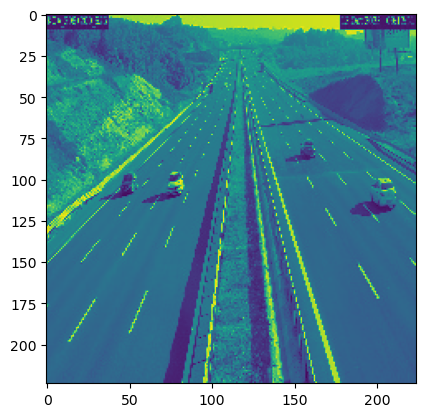

In [6]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open("/arf/home/edilek/KMO_Sample_Dataset/Training_dataset/206+200/Normal/000010.jpg")
plt.imshow(img)

import cv2 
# read image
img = cv2.imread('/arf/home/edilek/KMO_Sample_Dataset/Training_dataset/206+200/Normal/000010.jpg', cv2.IMREAD_UNCHANGED)
img

In [7]:
#@title Create Output Folders

def create_output_folders():
   
  if not os.path.exists("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Confusion_Matrix/"): 
      os.makedirs("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Confusion_Matrix/")
      
  if not os.path.exists("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/ROC/"):
      os.makedirs("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/ROC/")
      
  if not os.path.exists("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Accuracy/"):
      os.makedirs("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Accuracy/")
      
  if not os.path.exists("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Loss/"): 
      os.makedirs("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Loss/")

  if not os.path.exists("/arf/home/edilek/ViT_FT_Output/Models/" + choice +"/"): 
      os.makedirs("/arf/home/edilek/ViT_FT_Output/Models/" + choice + "/")

create_output_folders()

Resolving data files:   0%|          | 0/12733 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2547 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/638 [00:00<?, ?it/s]

train_set: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 12733
    })
})
validation_set: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2547
    })
})
test_set: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 638
    })
})
train_set["train"].features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Anomaly', 'Normal'], id=None)}
len_train_set: 12733  len_validation_set: 2547  len_test_set: 638
labels: ['Anomaly', 'Normal']
id2label: {0: 'Anomaly', 1: 'Normal'}
label2id: {'Anomaly': 0, 'Normal': 1}


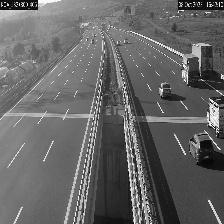

In [8]:
# Loading data

train_set      = load_dataset(paths.training_dataset) 
validation_set = load_dataset(paths.validation_dataset)
test_set       = load_dataset(paths.test_dataset)

print("train_set:", train_set)
print("validation_set:", validation_set)
print("test_set:", test_set)

print('train_set["train"].features:', train_set["train"].features)

len_train_set       = train_set["train"].num_rows
len_validation_set  = validation_set["train"].num_rows
len_test_set        = test_set["train"].num_rows
print("len_train_set:", len_train_set, " len_validation_set:",len_validation_set, " len_test_set:", len_test_set)

labels = train_set["train"].features["label"].names
print("labels:", labels)

id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}

print("id2label:", id2label)
print("label2id:", label2id)

example = train_set["train"][0]
example["image"]

In [9]:
# Define image processor

from transformers import AutoImageProcessor, ViTImageProcessor

image_processor = AutoImageProcessor.from_pretrained('facebook/convnext-tiny-224')
"""
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

image_processor = AutoImageProcessor.from_pretrained("snap-research/efficientformer-l1-300")

image_processor = AutoImageProcessor.from_pretrained("apple/mobilevit-small")

image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")

image_processor = AutoImageProcessor.from_pretrained("facebook/levit-128S")

image_processor = AutoImageProcessor.from_pretrained("google/vit-hybrid-base-bit-384")

image_processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")

image_processor = AutoImageProcessor.from_pretrained("nvidia/mit-b0")
"""
print(image_processor)

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



In [8]:
# Define transformation settings 

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

# We normalize manually for MobileViT model because it doesn't normalize by default.
# normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

transform = Compose(
    [
     ToTensor(),
     normalize
    ]
)

"""
# for ViT Hybrid model, we have to resize images, otherwise it gives error
transform = Compose(
    [
     ToTensor(),
     normalize,
     Resize((512, 512))
    ]
)
"""
def do_transforms(examples):
    examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples["image"]]  
    return examples

In [9]:
# Transform the datasets

processed_train_set      = train_set.with_transform(do_transforms)
processed_validation_set = validation_set.with_transform(do_transforms)
processed_test_set       = test_set.with_transform(do_transforms)

print("keys:", processed_train_set["train"][0].keys())
processed_train_set["train"][0]
#processed_train_set["train"][0]["image"]

keys: dict_keys(['image', 'label', 'pixel_values'])


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=224x224>,
 'label': 0,
 'pixel_values': tensor([[[-1.9124, -1.7412, -1.9124,  ..., -1.8097, -1.9980, -1.7925],
          [-1.7240, -1.9638, -1.6555,  ..., -1.9124, -1.7754, -1.8953],
          [-1.7412,  0.6734, -1.2274,  ...,  2.1119,  0.7248, -1.6727],
          ...,
          [-0.0287, -0.0287, -0.0458,  ..., -0.7650, -0.8849, -0.7993],
          [-0.0287, -0.0287, -0.0458,  ..., -1.1589, -0.6109, -1.0048],
          [-0.0116, -0.0287, -0.0458,  ...,  1.6324, -1.0219, -0.8678]],
 
         [[-1.8256, -1.6506, -1.8256,  ..., -1.7206, -1.9132, -1.7031],
          [-1.6331, -1.8782, -1.5630,  ..., -1.8256, -1.6856, -1.8081],
          [-1.6506,  0.8179, -1.1253,  ...,  2.2885,  0.8704, -1.5805],
          ...,
          [ 0.1001,  0.1001,  0.0826,  ..., -0.6527, -0.7752, -0.6877],
          [ 0.1001,  0.1001,  0.0826,  ..., -1.0553, -0.4951, -0.8978],
          [ 0.1176,  0.1001,  0.0826,  ...,  1.7983, -0.9153, -0.7577]],


In [10]:
# Define data loader and collate function that adds pixel values and labels to data loader

def collate_fn(examples):
  pixel_values = torch.stack([example["pixel_values"] for example in examples])
  labels = torch.tensor([example["label"] for example in examples])

  return {"pixel_values": pixel_values, "labels": labels}

train_loader = DataLoader(processed_train_set["train"], collate_fn=collate_fn, batch_size=128, shuffle=True)
valid_loader = DataLoader(processed_validation_set["train"], collate_fn=collate_fn, batch_size=128, shuffle=True)
test_loader = DataLoader(processed_test_set["train"], collate_fn=collate_fn, batch_size=128, shuffle=True)

batch = next(iter(train_loader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([128, 3, 224, 224])
labels torch.Size([128])


In [11]:
# Define model to be fine-tuned

from transformers import (AutoModelForImageClassification, ViTForImageClassification, SwinForImageClassification, Swinv2ForImageClassification,
EfficientFormerForImageClassification, MobileViTForImageClassification, ResNetForImageClassification, LevitForImageClassification,
ViTHybridForImageClassification, SegformerForImageClassification)


model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)
"""
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

model = EfficientFormerForImageClassification.from_pretrained("snap-research/efficientformer-l1-300")

model = MobileViTForImageClassification.from_pretrained("apple/mobilevit-small")

model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

model = LevitForImageClassification.from_pretrained("facebook/levit-128S")

model = ViTHybridForImageClassification.from_pretrained("google/vit-hybrid-base-bit-384")

model = Swinv2ForImageClassification.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")

model = SegformerForImageClassification.from_pretrained("nvidia/mit-b0")
"""

/arf/home/edilek/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'\nmodel = ViTForImageClassification.from_pretrained(\'google/vit-base-patch16-224-in21k\',\n                                                  id2label=id2label,\n                                                  label2id=label2id)\n\nmodel = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")\n\nmodel = EfficientFormerForImageClassification.from_pretrained("snap-research/efficientformer-l1-300")\n\nmodel = MobileViTForImageClassification.from_pretrained("apple/mobilevit-small")\n\nmodel = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")\n\nmodel = LevitForImageClassification.from_pretrained("facebook/levit-128S")\n\nmodel = ViTHybridForImageClassification.from_pretrained("google/vit-hybrid-base-bit-384")\n\nmodel = Swinv2ForImageClassification.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")\n\nmodel = SegformerForImageClassification.from_pretrained("nvidia/mit-b0")\n'

In [12]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    #print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
   
    N_EPOCHS = 3
    LR = 0.00005

    # Training loop
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    train_acc_values, val_acc_values, train_loss_values, val_loss_values = list(), list(), list(), list()

    train_time = 0.0
    valid_time = 0.0
    test_time = 0.0
    
    for epoch in trange(N_EPOCHS, desc="Training"):
        ###########################################################################
        print("Training epoch:", epoch+1)
        t0 = time.time()
        
        model.train(True)

        train_accuracy = 0.0    
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            # print("batch.shape:", batch[0].shape)  
            
            # move batch to GPU
            batch = {k:v.to(device) for k,v in batch.items()}
     
            x = batch["pixel_values"]
            y = batch["labels"]
            # print("x:", x, " y:", y)

            # Zero your gradients for every batch!
            optimizer.zero_grad()
            
            # Make predictions for this batch          
            y_hat = model(pixel_values = x, labels = y)

            # print("x.shape:", x.shape, " y.shape:", y.shape, " y_hat :", y_hat)

            # Compute the loss and its gradients
            loss, logits = y_hat.loss, y_hat.logits
            loss.backward()
            
            """
            print("loss:", loss)
            print("logits:", logits)
            """
            # Adjust learning weights
            optimizer.step()
            
            train_loss += loss.item() / len(train_loader)

            # metrics
            acc = (logits.argmax(-1) == y).float().mean()
            train_accuracy += acc / len(train_loader)
        
        t1 = round(time.time() - t0)
        train_time = train_time + t1
        ###########################################################################
        
        print("Validating epoch:", epoch+1)
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.      
        t0 = time.time()
        
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            val_accuracy = 0.0
            val_loss = 0.0
            
            for batch in tqdm(valid_loader, desc="Validating"):             
                # move batch to GPU
                batch = {k:v.to(device) for k,v in batch.items()}
         
                x = batch["pixel_values"]
                y = batch["labels"]
                y_hat = model(pixel_values = x, labels = y)

                loss, logits = y_hat.loss, y_hat.logits           
                val_loss += loss.item() / len(valid_loader)

                # metrics
                acc = (logits.argmax(-1) == y).float().mean()
                val_accuracy += acc / len(valid_loader)
        
        t1 = round(time.time() - t0)
        valid_time = valid_time + t1
        ###########################################################################
        # Store train/validation acc/loss history 
        
        train_acc_values.append(torch.round(train_accuracy, decimals=2))
        val_acc_values.append(torch.round(val_accuracy, decimals=2))
        
        train_loss_values.append(torch.round(torch.as_tensor(train_loss), decimals=2))
        val_loss_values.append(torch.round(torch.as_tensor(val_loss), decimals=2))
        
        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.4f}")
        print(f"Epoch : {epoch+1} - loss : {train_loss:.4f} - acc: {train_accuracy:.4f} - val_loss : {val_loss:.4f} - val_acc: {val_accuracy:.4f}\n")
        ###########################################################################
    
    # Save the model's state
    torch.save(model.state_dict(), model_path)

    #############################################################################
    # Draw Training/Validation Accuracy Graph
    acc     = train_acc_values
    val_acc = val_acc_values
    
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 10))
    plt.plot(torch.stack(train_acc_values).cpu().numpy(), label='Training Accuracy')  
    plt.plot(torch.stack(val_acc_values).cpu().numpy(), label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.ylim([min(plt.ylim()), 1])
    plt.legend(loc='lower left')
    plt.title(model_name)
    plt.savefig(("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Accuracy/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
    plt.show()

    # Draw Training/Validation Loss Graph
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 10))
    plt.plot(torch.stack(train_loss_values).cpu().numpy(), label='Training Loss')
    plt.plot(torch.stack(val_loss_values).cpu().numpy(), label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.ylim([min(plt.ylim()), 1])
    plt.legend(loc='lower left')
    plt.title(model_name)
    plt.savefig(("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Loss/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
    plt.show()
    ###############################################################################
    
    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        predictions, actuals = list(), list()
        
        for batch in tqdm(test_loader, desc="Testing"):
            t0 = time.time()

            # move batch to GPU
            batch = {k:v.to(device) for k,v in batch.items()}
     
            x = batch["pixel_values"]
            y = batch["labels"]
            y_hat = model(pixel_values = x, labels = y)

            t1 = round(time.time() - t0)
            test_time = test_time + t1
        
            loss, logits = y_hat.loss, y_hat.logits  
            test_loss += loss.item() / len(test_loader)
            
            # tahmin edilen sinif = en yuksek degere sahip sutun indeksi
            correct += torch.sum(y_hat.logits.argmax(-1) == y).detach().cpu().item() 
            total += len(x)

            #print("x.shape:", x.shape, "y.shape:", y.shape, " y_hat.shape:", y_hat.shape)
            #print("y[0]:", y[0], " y_hat[0,0]:", y_hat[0,0], " y_hat[0,1]:", y_hat[0,1])

            ############ Calculate accuracy in a different way ###########
            
            #print("yhat shape1:", y_hat.shape)
            # retrieve numpy array
            y_hat = y_hat.logits.detach().cpu().numpy()
            #print("yhat shape2:", y_hat.shape)
            # round to class values
            y_hat = y_hat.round() 
            
            actual = y.detach().cpu().numpy()
            actual = actual.reshape((len(actual), 1))                       
            
            # store y_hat and actual values
            p = np.argmax(y_hat, axis=1).reshape((len(y_hat), 1)) # tahmin edilen sinif = en yuksek degere sahip sutun indeksi
            #print("actual[0]:", actual[0], " y_hat[0,0]:", y_hat[0,0], " y_hat[0,1]:", y_hat[0,1])            
            predictions.append(p) 
            actuals.append(actual)    
            #print("actual.shape:", actual.shape, " y_hat.shape:", y_hat.shape, " prediction.shape:", p.shape)
            #print("actual:", actual," prediction:", p)
            ###########################################################            
            
        print(f"Test loss: {test_loss:.4f} Test accuracy: {correct / total * 100:.2f}%")
        
        ############ Calculate accuracy in a different way ###########
        predictions, actuals = vstack(predictions), vstack(actuals)
        acc = metrics.accuracy_score(actuals, predictions)         
        print(f"Test accuracy 2: {acc * 100:.2f}%")

        print("actuals.shape:", actuals.shape, " predictions.shape:", predictions.shape)
        actuals = tf.squeeze(actuals)
        predictions = tf.squeeze(predictions)
        ##############################################################
        print("\n")
        print(f"Training time: {train_time:.4f}s Validation time: {valid_time:.4f}s Test time: {test_time:.4f}s")
        print(f"Training time of a frame: {(train_time/len_train_set):.4f}s")
        print(f"Validation time of a frame: {(valid_time/len_validation_set):.4f}s")
        print(f"Prediction time of a frame: {(test_time/len_test_set):.4f}s")
        if test_time > 0 :
            fps = round(len_test_set/test_time)
            print(f"fps: {fps}")
        
        ############################################################################
        # Calculation of Metrics
        # Accuracy = metrics.accuracy_score(actual, predicted)
        # Precision = metrics.precision_score(actual, predicted)
        # Sensitivity_recall = metrics.recall_score(actual, predicted)
        # Specificity = metrics.recall_score(actual, predicted, pos_label=0)
        # F1_score = metrics.f1_score(actual, predicted)

        #############################################################################
        
        # Create Confusion Matrix

        TP, FN, FP, TN = confusion_matrix(actuals, predictions).ravel()

        print('\n')
        print('True Positive(TP)  = ', TP)
        print('False Positive(FP) = ', FP)
        print('True Negative(TN)  = ', TN)
        print('False Negative(FN) = ', FN)
        accuracy =  (TP + TN) / (TP + FP + TN + FN)
        precision = TP/(TP + FP)
        recall = TP / (TP + FN)
        F1_score = (2 * precision * recall)/(precision + recall)
        print('Accuracy = {:0.4f}'.format(accuracy), ' Precision = {:0.4f}'.format(precision), ' Recall = {:0.4f}'.format(recall), ' F1 Score = {:0.4f}'.format(F1_score))
        print('\n')  

        cm = tf.math.confusion_matrix(actuals, predictions)
        cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
        plt.figure(figsize=(10, 7))
        sbn.set(font_scale=1.6)
        sbn.heatmap(cm,cmap="YlGnBu",cbar=False, xticklabels=['Anomaly','Normal'], yticklabels=['Anomaly','Normal'], annot=True, fmt='.4f')
        plt.title(model_name)
        plt.xlabel('Predicted',labelpad=10)
        plt.ylabel('Actual',labelpad=10)
        plt.savefig(("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Confusion_Matrix/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
        plt.show()
        #############################################################################

        #############################################################################
        # Create Classification Report
        from sklearn.metrics import classification_report
        target_names = ['Anomaly','Normal']
        print(classification_report(actuals, predictions, target_names=target_names))
        #############################################################################

        #############################################################################
        # Draw ROC Curve
        fpr,tpr,thresholds = metrics.roc_curve(actuals, predictions)
        auc = metrics.roc_auc_score(actuals, predictions)
        print("AUC = {:0.4f}".format(auc))
        plt.figure(figsize=(10, 7))
        plt.title("Camera No:"+ choice +" ROC Curve")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.plot(fpr,tpr, label='ROC curve of '+ model_name.upper() +' (AUC = '+  "{:.4f}".format(auc)+')')
        plt.legend(fontsize="xx-small", bbox_to_anchor =(1.0, 0.07), loc='lower right')
        plt.axhline(0, color="black", alpha=0.3)
        plt.axvline(0, color="black", alpha=0.3)
        plt.savefig(("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/ROC/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
        plt.show()
        #############################################################################
        

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training epoch: 1



Epoch 1 in training: 100%|██████████| 100/100 [05:47<00:00,  2.95s/it]
                                                                      

Validating epoch: 1



Training:  33%|███▎      | 1/3 [06:00<12:01, 360.85s/it]

Epoch 1/3 loss: 0.1289
Epoch : 1 - loss : 0.1289 - acc: 0.9402 - val_loss : 0.0150 - val_acc: 0.9964

Training epoch: 2



Epoch 2 in training: 100%|██████████| 100/100 [05:47<00:00,  3.07s/it]
                                                                      

Validating epoch: 2



Training:  67%|██████▋   | 2/3 [11:59<05:59, 359.83s/it]

Epoch 2/3 loss: 0.0118
Epoch : 2 - loss : 0.0118 - acc: 0.9960 - val_loss : 0.0017 - val_acc: 0.9996

Training epoch: 3



Epoch 3 in training: 100%|██████████| 100/100 [05:44<00:00,  2.96s/it]
                                                                      

Validating epoch: 3



Training: 100%|██████████| 3/3 [17:55<00:00, 358.52s/it]


Epoch 3/3 loss: 0.0034
Epoch : 3 - loss : 0.0034 - acc: 0.9991 - val_loss : 0.0093 - val_acc: 0.9977



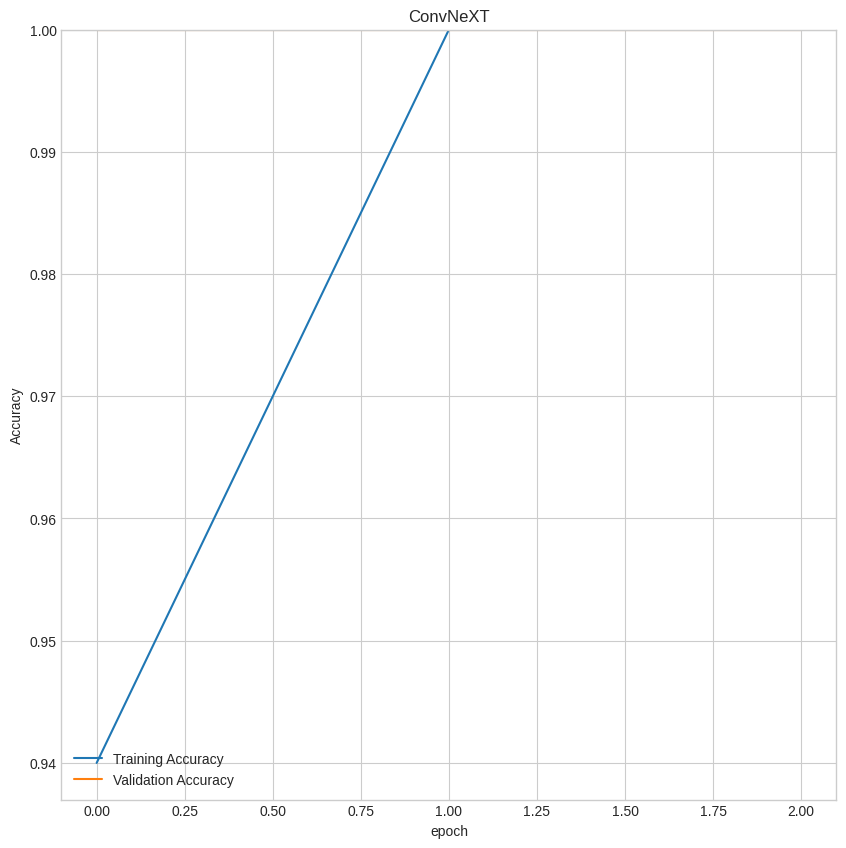

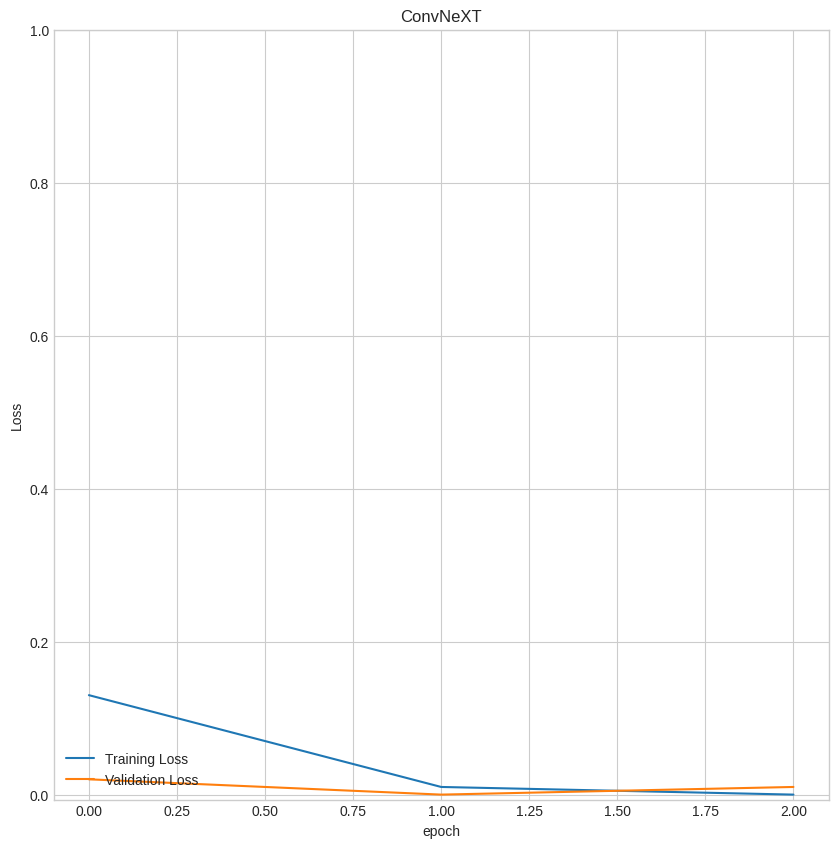

Testing: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Test loss: 0.0015 Test accuracy: 100.00%
Test accuracy 2: 100.00%
actuals.shape: (638, 1)  predictions.shape: (638, 1)


Training time: 1041.0000s Validation time: 35.0000s Test time: 0.0000s
Training time of a frame: 0.0818s
Validation time of a frame: 0.0137s
Prediction time of a frame: 0.0000s


True Positive(TP)  =  145
False Positive(FP) =  0
True Negative(TN)  =  493
False Negative(FN) =  0
Accuracy = 1.0000  Precision = 1.0000  Recall = 1.0000  F1 Score = 1.0000




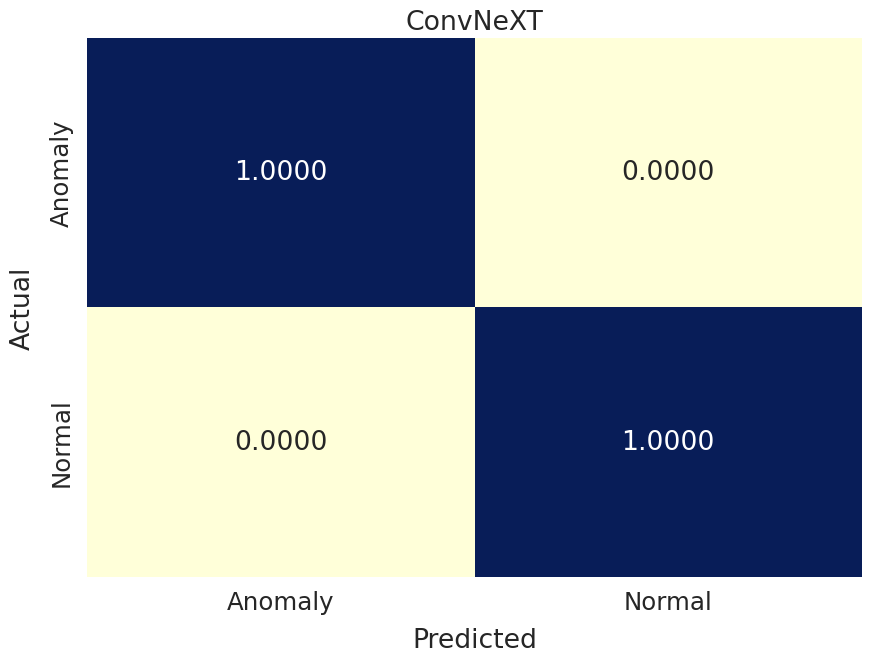

              precision    recall  f1-score   support

     Anomaly       1.00      1.00      1.00       145
      Normal       1.00      1.00      1.00       493

    accuracy                           1.00       638
   macro avg       1.00      1.00      1.00       638
weighted avg       1.00      1.00      1.00       638

AUC = 1.0000


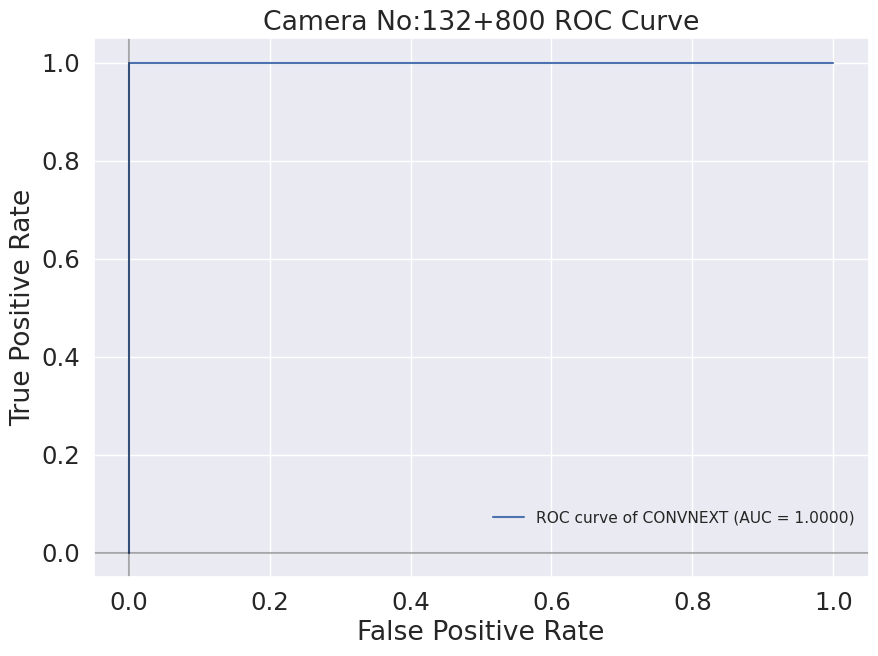

In [13]:
main()